<a href="https://colab.research.google.com/github/lustea0201/Biomedical-Data-Science/blob/master/Data_analysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the second dataset 

In [122]:
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 

torch.manual_seed(0) # Reproducible, for now 

dtype = torch.float
device = torch.device("cpu") 

FIGSIZE = (12,10)

!rm -rf main_dir
!rm -rf data.zip

m = 2 # 1 to import local file, 2 to import from drive

if (m == 1): 
  from google.colab import files
  uploaded = files.upload()
  data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')

if (m == 2): 
  from google.colab import drive
  drive.mount('/content/drive/')

  data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/1000/data2/data.zip", 'r')



root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

transforms = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transforms)

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transforms)

idx_to_class = {j:i for i,j in train_data.class_to_idx.items()}


# Dataset description 


*   Label 0: the image doesn't contain any crosses 
*   Label 1: the image contains at least one cross 
Here are two examples: 



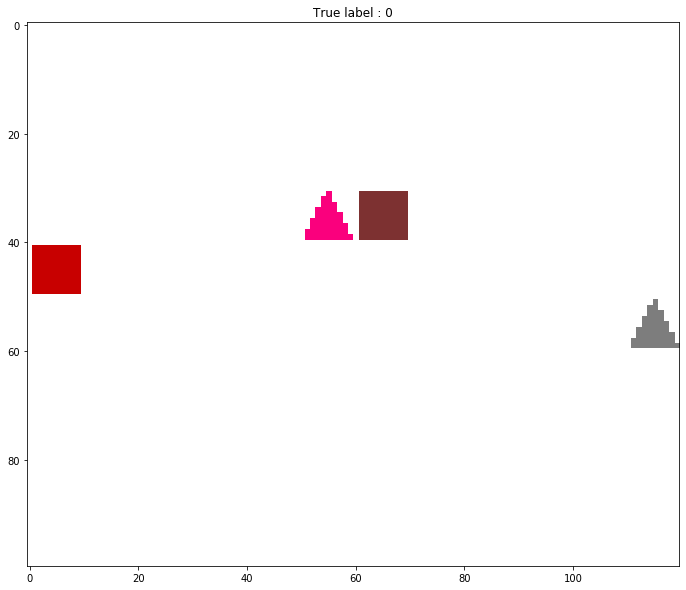

In [124]:


def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[true_label]
  
  if (predicted_label != None):
    title_ += "/ Predicted : " + idx_to_class[predicted_label]


  plt.title(title_)

display_image(train_data[0][0], train_data[0][1])




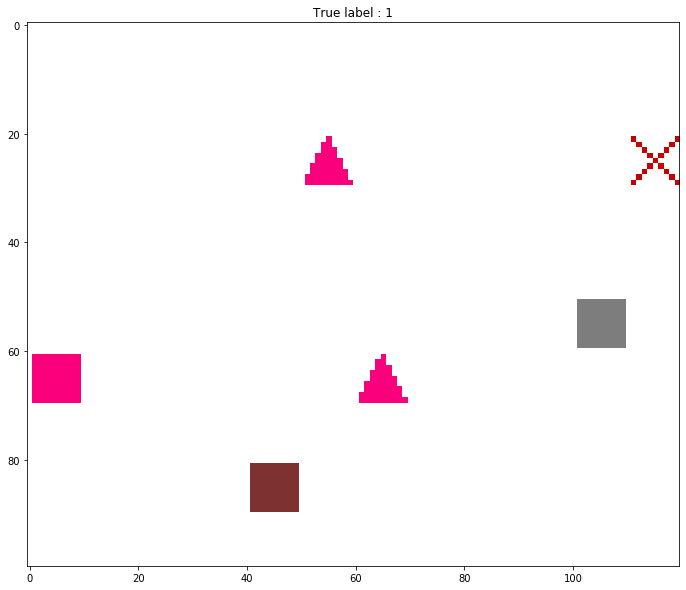

In [125]:
display_image(train_data[-1][0], train_data[-1][1])

In [0]:
batch_Size = 4
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)

train_loader = iter(dataloader)
x,y = next(train_loader)



# Model description
The neural network used to classify the images receives batches of 3x100x120 images. 
It consists of 
* two convolutional layers followed by max pooling 
* three fully connected layers

https://www.youtube.com/watch?v=fXEdtz8U3Sc

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net().to(device)


The network is implemented with cross entropy loss and L2 regularization. 

In [0]:
import torch.optim as optim

regularization_strength = 0.001
learning_rate = 0.001
mom = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = mom, weight_decay = regularization_strength)

In [174]:
max_epochs = 1000
out_period = 0.5*len(train_data)/batch_Size # twice per generation
plot_period = out_period # also  times per generation
converged = False
epsilon = 0.001

def almost_equal(n1, n2, e): 
  return abs(n1-n2) < e

loss_list = []
for epoch in range(max_epochs):  # loop over the dataset multiple times

  running_loss_plot = 0.0
  running_loss_out = 0.0
  if not converged: 
    for i, data in enumerate(dataloader, 0):
      
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # plot loss 
      running_loss_plot += loss.item()
      running_loss_out += loss.item()

      if (i % plot_period == (plot_period - 1)):    
        loss_list.append(running_loss_plot/plot_period)
        running_loss_plot = 0.0

      if (i % out_period == (out_period - 1)):    # print every 200 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss_out / out_period))
          running_loss_out = 0.0

      if (len(loss_list) > 4): 
        c = almost_equal(loss_list[-4], loss_list[-3], epsilon) 
        c = c and almost_equal(loss_list[-3], loss_list[-2], epsilon) 
        converged = c and almost_equal(loss_list[-2], loss_list[-1], epsilon)
  
if (converged): 
  print ("Network has converged.")
else: 
  print("Network hasn't been able to converge in " + str(max_epochs) + " generations.")

          



[1,   250] loss: 0.694
[1,   500] loss: 0.693
[2,   250] loss: 0.691
[2,   500] loss: 0.692
[3,   250] loss: 0.691
[3,   500] loss: 0.687
[4,   250] loss: 0.681
[4,   500] loss: 0.671
[5,   250] loss: 0.619
[5,   500] loss: 0.362
[6,   250] loss: 0.070
[6,   500] loss: 0.075
[7,   250] loss: 0.024
[7,   500] loss: 0.016
[8,   250] loss: 0.005
[8,   500] loss: 0.002
[9,   250] loss: 0.002
[9,   500] loss: 0.002
[10,   250] loss: 0.001
[10,   500] loss: 0.001
Network has converged.


Text(0, 0.5, 'Evaluation of the loss function')

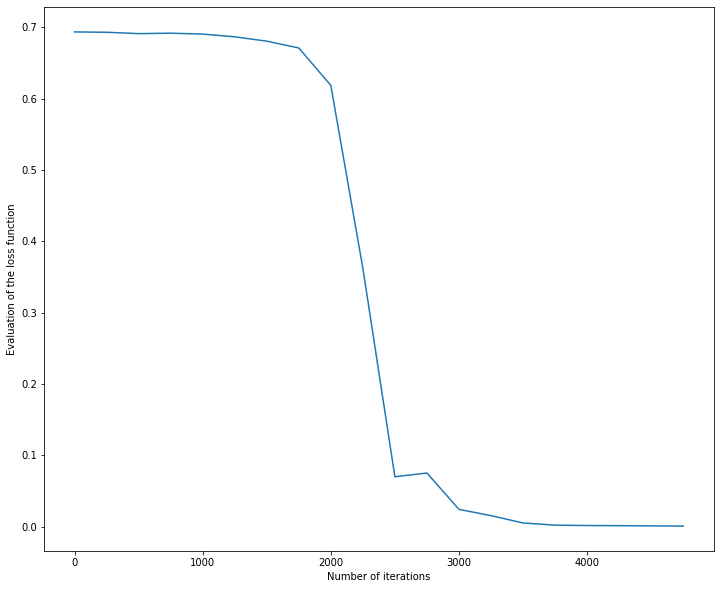

In [175]:
plt.figure(figsize = FIGSIZE)
x_scale = plot_period*np.linspace(0, len(loss_list)- 1, len(loss_list) )
_ = plt.plot(x_scale, loss_list)
plt.xlabel("Number of iterations")
plt.ylabel("Evaluation of the loss function")

In [176]:
correct = 0
total = 0
wrong_im = []
wrong_label = []
wrongly_predicted_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        k = 0
        for truth in (predicted == labels): 
          if not truth: 
            wrong_im.append(images[k])
            wrong_label.append(int(labels[k]))
            wrongly_predicted_label.append(int(predicted[k]))
          k += 1
        
        

print("Accuracy of the network on the " + str(total) + ' test images: %d %%' % (
    100 * correct / total))

print("Number of mistakes : " +str(total-correct))
index = 0

Accuracy of the network on the 2000 test images: 99 %
Number of mistakes : 4


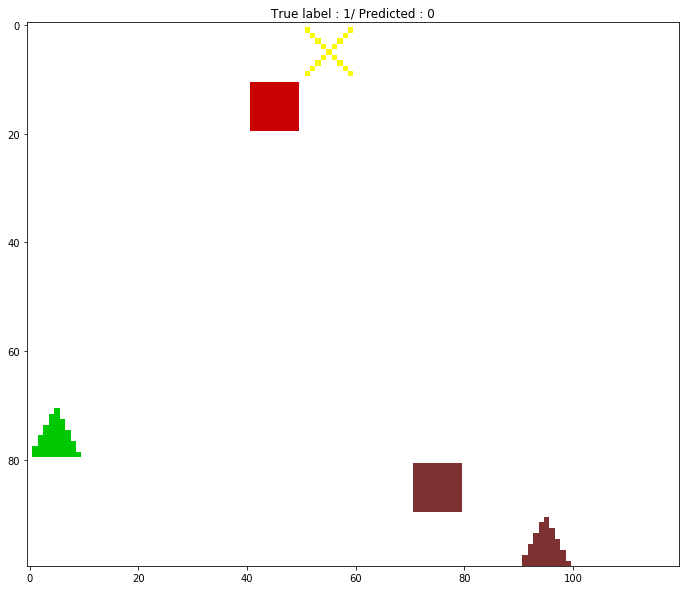

In [177]:
if index in range(len(wrong_im)):
  display_image(wrong_im[index], wrong_label[index], wrongly_predicted_label[index])
  index += 1

In [0]:
index = 0